<a href="https://colab.research.google.com/github/Bigdata-webtoon-recommendation/webtoon-recommend/blob/main/Final%20Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Library

In [1]:
pip install konlpy

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install gensim

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install fastparquet

Note: you may need to restart the kernel to use updated packages.


In [1]:
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

from konlpy.tag import Komoran
from konlpy.tag import Kkma
from re import match
from gensim.models.word2vec import Word2Vec

from fastparquet import write

## **[INPUT(나이 / 좋아하는 웹툰)]**
## 옵션 1: q를 입력받을 때까지 계속 받음, 3개 이상

+ 19세 이하일 경우 성인용 웹툰 data에서 삭제
+ 평점 상위 10% 에는 가중치 높게, 하위 10% 에는 가중치 낮게, 나머지는 동일

In [2]:
# 전체 네이버 + 다음 웹툰 갯수 2383개 // 네이버 1- 1181, 다음 1182 - 2383
data = pd.read_csv("./naver_daum_integration_v4.csv")
#data.last_valid_index

# 추천 점수 저장할 리스트 선언 (data의 idx(1~2383)을 인덱스로)
recommend_score = [0 for i in range(len(data)+1)]

# 나이 입력받기
age = input('나이를 입력하세요: ')

# 잘못 입력했을 경우 정확히 입력할 때까지 반복
while not age.isdigit():
    age = input('정확한 나이를 입력하세요: ')
    if age.isdigit():
        break
    
# 전체 웹툰 제목 받아오기 (input 값 비교용)
title = np.array(data['name'].tolist())
keywords = np.array(data['keywords'].tolist())

# 입력한 웹툰의 제목을 저장하는 리스트
input_list = []

# q를 입력할 때까지 좋아하는 웹툰 제목을 입력받음, 무조건 세 개 이상 입력해야함, 중복 입력 불가능
while 1:
    a = input('좋아하는 웹툰을 입력하세요(q 입력 시 종료): ')
    if a == 'q':
        if len(input_list) >= 3:
            break
        else:
            print("웹툰을 세 개 이상 입력하세요")
    elif a not in title:
        print('입력한 웹툰이 존재하지 않습니다.')
    elif a in input_list:
        print('중복된 웹툰입니다.')
    else:
        input_list.append(a)

# like_list에 입력받은 웹툰 정보를 저장, 각 요소는 Series type으로 되어있음
like_list = []
for i in input_list:
    like_list.append(data[data.name == i])

# like_list에 저장된 각 요소를 하나의 DataFrame으로 합쳐줌 -> like_df에는 입력받은 웹툰들이 DataFrame의 행 형태로 있음
like_df = like_list[0]
for i in like_list[1:]:
    like_df = pd.concat([like_df, i])

like_df_genre = like_df[['g1','g2','g3','g4','g5','g6','g7','g8','g9','g10','g11']]
like_df_keywords = like_df[['keywords']]

나이를 입력하세요: 23
좋아하는 웹툰을 입력하세요(q 입력 시 종료): 호랑이 들어와요
좋아하는 웹툰을 입력하세요(q 입력 시 종료): 이것도 친구라고
좋아하는 웹툰을 입력하세요(q 입력 시 종료): 블랙윈터
좋아하는 웹툰을 입력하세요(q 입력 시 종료): 신비
좋아하는 웹툰을 입력하세요(q 입력 시 종료): q


# **[ 추천 알고리즘 구현 정리 ]**

* Content-based 에서 사용하는 features

  * 제목/작가/ **평점** / 연령정보 / **장르** / **키워드**
    * 작가는 추후 고려요소! (or 작가는 너무 같은작가가 별로 없는 편이니까 마지막에 top30정도 추리고 나서 가중치 둬서 올리는 식으로)

* 먼저 연령정보 기반으로 필터링 진행

* 결론적으로 content-based에서 최종score에 반영되는것은
    * **평점(rating_score)**
    * **장르(genre_score)**
    * **키워드(story_score)**
    * **(recommend_score) = rating_score * w1 + genre_score * w2 + story_score * w3**

* (recommend_score)을 naver_daum_integration_v2.csv의 각 행, 즉 각 웹툰에 대해 모두 계산해 두어야 함

* (recommend_score) 계산한거 sorting 해서 top30 뽑은 후 적당히 작가 같은거 있으면 점수 올려주는 식으로..


## **연령정보 기반으로 필터링**

In [3]:
# 입력받은 나이가 19세 미만이면 19세 웹툰은 data(추천 데이터셋)에서 삭제
if int(age) < 19:
    data = data[data.age_limit != 1]

## **평점별 점수 (rating_score) 계산**

In [7]:
# score의 내림차순으로 정렬한 data를 score_arrange_data에 저장
score_arrange_data = data.sort_values(by=['score'], axis=0, ascending=False)

# data 개수의 10%는 238개
ten_percent = round(len(data) * 0.1)

# 상위 10%의 가장 낮은 점수(9.96)과 하위 10%의 가장 높은 점수(8.96)를 저장 (동점인 항목까지 가중치 부여에 포함하기 위함)
high_score = score_arrange_data.iloc[ten_percent - 1].score
low_score = score_arrange_data.iloc[len(data)-ten_percent].score

# score가 높은 index(291개), score가 낮은 index(238개)를 배열에 각각 저장
high_score_list = data[data['score'] >= high_score].index.values
low_score_list = data[data['score'] <= low_score].index.values

rating_score = np.zeros([len(data)])

for i in range (0, 2383):
    rating_score[i] = 0.5

# score가 높은 웹툰과 낮은 웹툰에 해당하는 idx의 recommend score 점수에 가중치 부여 (각각 1과 0)
for i in high_score_list:
    rating_score[i] = 1
    
for i in low_score_list:
    rating_score[i] = 0

print(rating_score)

[0.5 1.  1.  ... 0.5 0.5 0.5]


238

## **장르별 유사도 점수 (genre_score) 계산**

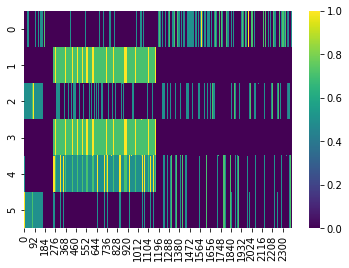

(6, 2383)

In [8]:
# 현재 모든 웹툰 데이터(naver_daum_integration_v2.csv 읽어온 데이터) 는 data라는 dataframe에 저장되어 있음
# g1, ... , g12 를 뽑아서 -> cos sim 비교
data_genre = data
data_genre = data_genre[['g1','g2','g3','g4','g5','g6','g7','g8','g9','g10','g11']]

cosine_sim_val = cosine_similarity(like_df_genre,data_genre)

sns.heatmap(cosine_sim_val, cmap='viridis')
plt.show()

cosine_sim_val.shape

In [9]:
# 사용자가 선호하는 웹툰(n개)에 대해 각각 2380?개의 총 웹툰과의 유사도가 나온 상태.
# 즉 cosin_sim_val의 shape 는 (n, 2383)
# 웹툰 2380개에 대해 각각의 genre_score을 이 n개에서 각각 나온 score을 더해서 평균내고
# 마지막으로 normalize하여 점수 저장

cosine_sim_avg = np.zeros([len(data)])
for i in range (0, len(like_df)):
    cosine_sim_avg = cosine_sim_avg + cosine_sim_val[i]

c_max = cosine_sim_avg.max()
c_min = cosine_sim_avg.min()

cosine_sim_avg_norm = (cosine_sim_avg - c_min) / (c_max - c_min)
#plt.plot(cosine_sim_avg_norm)
#plt.show()
genre_score = cosine_sim_avg_norm

## **키워드 점수 (story_score) 계산**

In [10]:
# 한줄 스토리에서 추출한 키워드를 csv데이터에서 추출
integration_data = pd.read_csv("./naver_daum_integration_v4.csv")
integration_keywords = integration_data[['keywords']]

# training keywords dataset을 생성
keywords_list = integration_keywords.values.tolist()
training_keywords = []
temp =[]
for i in range(len(keywords_list)):
    temp_genre = ''.join(keywords_list[i])
    temp_genre = temp_genre.replace("'","")
    temp_genre = temp_genre.replace("[","")
    temp_genre = temp_genre.replace("]","")
    temp_genre = temp_genre.replace(" ","")
    for word in temp_genre.split(','):
        temp.append(word)
    training_keywords.append(temp.copy())
    temp.clear()

In [11]:
# 워드투벡터 모델 training
keywords_model = Word2Vec(training_keywords, sg=1,window=4, min_count=1,iter=50)
keywords_model.init_sims(replace=True)

# 인풋으로 받은 웹툰의 키워드를 인풋으로 저장
input_words = []

for i in range (0, len(input_list)):
    str = like_df_keywords.keywords.values[i][1:-1].replace("'","")
    input_words.append(str.split(', '))

In [12]:
# 스토리에서 추출한 키워드 기반으로 유사도 계산
similarity_scores_for_all =[]

for k in range (0, len(input_list)):
    input_keywords = input_words[k] #integration_keywords[0]
    empty_list=[]
    similarity_score_result = []
    for compare_keywords in training_keywords:
        sum=0
        for compare_word in compare_keywords:
            for input_word in input_keywords:
                similarity = keywords_model.wv.similarity(compare_word, input_word)
                sum+=similarity
        try:
            avg=sum/(len(compare_keywords)*len(input_keywords))
            similarity_score_result.append(avg)
        except:
            similarity_score_result.append(empty_list.copy())
    similarity_scores_for_all.append(similarity_score_result.copy())

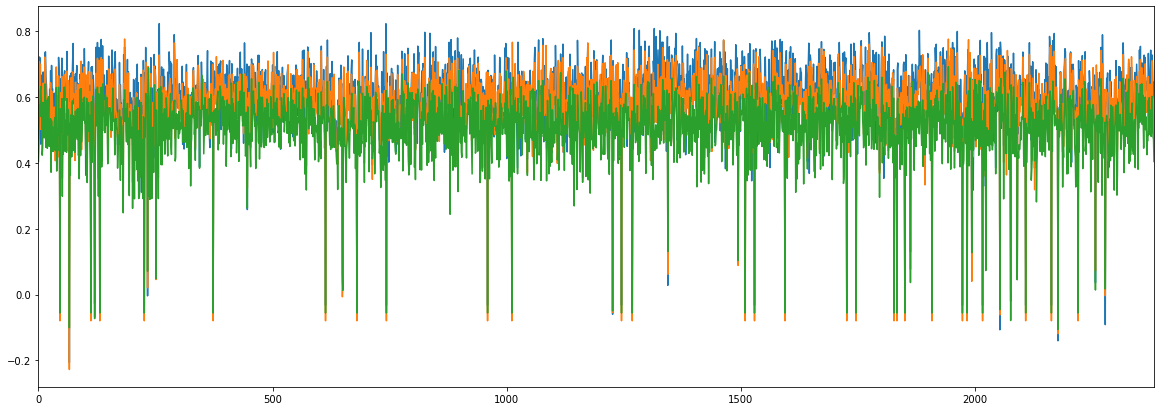

In [13]:
plt.figure(2, figsize = (20,7))

# 예시로 3개만 띄워봄
plt.plot(similarity_scores_for_all[0])
plt.plot(similarity_scores_for_all[1])
plt.plot(similarity_scores_for_all[2])
# plt.plot(similarity_scores_for_all[3])
# plt.plot(similarity_scores_for_all[4])
# plt.plot(similarity_scores_for_all[5])
plt.xlim([0,2383])
plt.show()


In [14]:
# 입력한 개수만큼의 웹툰 스토리와 유사한거 평균내서 similarity_final_score로 저장
similarity_score_avg = np.zeros([len(data)])[:,None]
similarity_final_score = np.mean(similarity_scores_for_all, axis = 0)

# story_ score 저장
story_score = np.zeros([len(data)])[:,None]
story_score = similarity_final_score


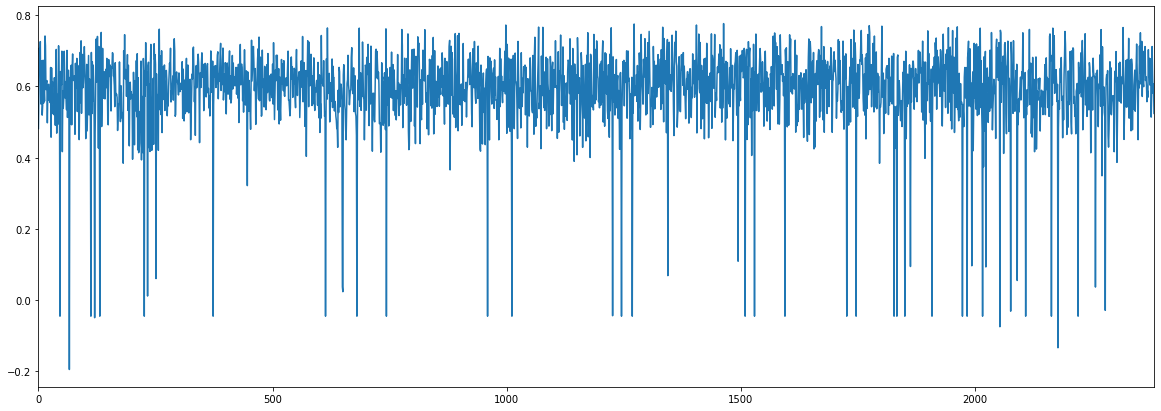

In [15]:
plt.figure(2, figsize = (20,7))
plt.plot(story_score)
plt.xlim([0,2383])
plt.show()

## **결과점수 (recommend_score) 계산**

In [16]:
# np.std(recommend_score)

In [17]:
# recommend_score_plot = recommend_score[:,None]
# plt.figure(3, figsize = (20,1))
# sns.heatmap(recommend_score_plot.T, cmap='viridis')
# plt.show()

# **User-based CF (comment_score) 계산**

In [18]:
# 비슷한 사용자 k 명 찾기
from sklearn.metrics.pairwise import cosine_similarity
import operator

def similar_users(user_id, matrix, k=10):    # k 는 10명으로 지정
    # create a df of just the current user
    user = matrix[matrix.index == user_id]
    
    # and a df of all other users
    other_users = matrix[matrix.index != user_id]
    
    # calc cosine similarity between user and each other user
    similarities = cosine_similarity(user,other_users)[0].tolist()
    
    # create list of indices of these users
    indices = other_users.index.tolist()
    
    # create key/values pairs of user index and their similarity
    index_similarity = dict(zip(indices, similarities))
    
    # sort by similarity
    index_similarity_sorted = sorted(index_similarity.items(), key=operator.itemgetter(1))
    index_similarity_sorted.reverse()
    
    # grab k users off the top
    top_users_similarities = index_similarity_sorted[:k]
    users = [u[0] for u in top_users_similarities]

    return users

In [19]:
df=pd.read_parquet('trying.parquet',engine='fastparquet')

In [20]:
# similar_user_indices에는 유사도가 높은 사용자 k명의 아이디가 저장됨
new_user = {input_list[i]: 1 for i in range(0, len(input_list))}
df.loc['user_input'] = new_user

df=df.fillna(0)
current_user = "user_input"

similar_user_indices = similar_users(current_user, df)
print(similar_user_indices)

ValueError: cannot set a row with mismatched columns

In [ ]:
# web에는 유사도 높은 사용자 순서대로 사용자가 댓글 단 웹툰 제목이 저장됨
web = []

for i in range(0, len(similar_user_indices)):
    person_comment = np.where(df.loc[similar_user_indices[i]].values != 0)[0]
    comment_web = []
    for j in person_comment:
        comment_web.append(df.columns[j])
    web.append(comment_web)

#web


In [ ]:
# comment_score는 유사도 높은 사용자가 읽은 웹툰일수록 높은 숫자 저장
comment_score = np.zeros([len(data)]) ###[:,None]
a = 0.01

for i in web[::-1]:
    for j in i:
        comment_score[np.where(title == j)] = a
    a += 0.01
    
#comment_score

In [ ]:
comment_score.shape

In [ ]:
rating_score.shape

In [ ]:
# weight setting
w1 = 0.2
w2 = 0.4
w3 = 0.4

recommend_score = rating_score * w1 + genre_score * w2 + story_score * w3 + comment_score

# plotting
plt.figure(2, figsize = (20,7))
plt.plot(recommend_score)
plt.xlim([0,2383])
plt.show()

print("========= item based 추천 결과 =======")

sorted_result = recommend_score.argsort();

# 중복 제거 전 출력하려면 아래 주석제거
# for i in range (1,21):
#   print(i,"위 :  ", recommend_score[sorted_result[-i]],"  ", title[sorted_result[-i]])

print("========== 중복 제거 후 =========")

num = 0
for i in recommend_score.argsort()[::-1]:
    if title[i] in input_list:
        continue
    else:
        if num == 20:
            break
        else:
            print(recommend_score[i], title[i])
            num += 1

#recommend_score = recommend_score[:,None]

## 마지막 순위 추출 후 상위 30개 이내에 같은 작가가 있을 경우 가산점 부여하여 추출

In [ ]:
like_writer = []

for i in recommend_score.argsort()[:-31:-1]:
    a = title[i]
    a = data.loc[data['name'] == a].writer.values[0]
    if a in like_writer:
        if title[i] in input_list:
            continue
        else:
            recommend_score[i]  += 0.01
            print(title[i], recommend_score[i]) ##출력 안되면 같은 작가 없는 경우
